Closest filenames:
204331.jpg
204740.jpg
205655.jpg
203783.jpg
22230273.jpg
204549.jpg
203571.jpg
203638.jpg
7793987.jpg
7793375.jpg


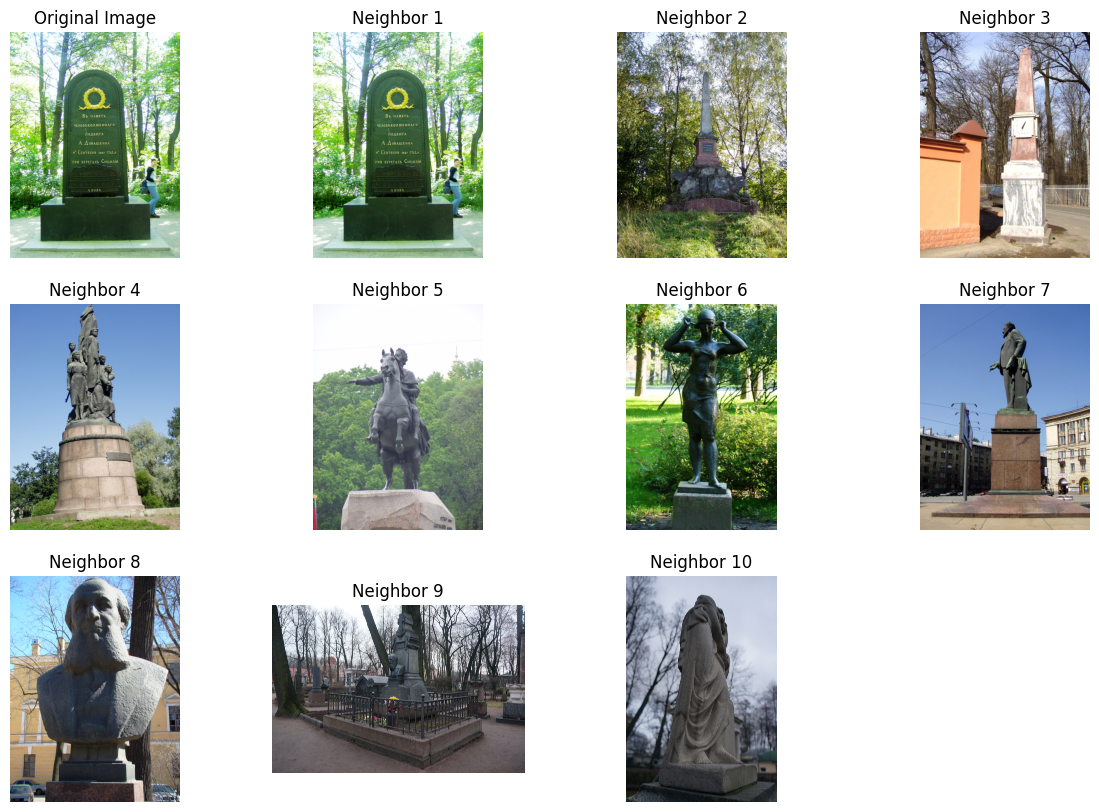

In [23]:
import torch
import numpy as np
from torch import nn
from torchvision import transforms
from torchvision.models import resnet50
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision.models.resnet import ResNet50_Weights

# Определение модели
class SimpleResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.base_model(x)

num_classes = 15
device = torch.device("cuda")

model = SimpleResNet(num_classes)
model.load_state_dict(torch.load("C:/Users/user/Desktop/госкатлог/best_model-8b-256picV2.pth"))
model.base_model.fc = nn.Identity()
model = model.to(device)
model.eval()


# Функция для преобразования изображения в эмбеддинг
def image_to_embedding(image_path, model, device):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(image)
    return embedding.cpu().numpy()


# Загрузка нового изображения и получение эмбеддинга
new_image_path = r"C:/Users/user/Desktop/госкатлог/train-t/204331.jpg"
new_embedding = image_to_embedding(new_image_path, model, device)

# Загрузка сохраненных эмбеддингов и имен файлов
embeddings = np.load(r"saved_embeddings.npy")
filenames = np.load(r"saved_labels.npy", allow_pickle=True)

# Инициализация и обучение модели ближайших соседей
neighbors = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')
neighbors.fit(embeddings)

# Поиск 10 ближайших эмбеддингов в базе
distances, indices = neighbors.kneighbors(new_embedding)

# Получение имен файлов с наиболее близкими эмбеддингами
closest_filenames = filenames[indices[0]]
print("Closest filenames:")
for filename in closest_filenames:
    print(filename)

# Визуализация изображений
def plot_images(main_image_path, similar_images):
    plt.figure(figsize=(15, 10))
    # Отображение исходного изображения
    img = Image.open(main_image_path)
    plt.subplot(3, 4, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    
    # Отображение похожих изображений
    for idx, filename in enumerate(similar_images, 2):
        img_path = os.path.join(r"C:/Users/user/Desktop/госкатлог/train-t", filename)
        img = Image.open(img_path)
        plt.subplot(3, 4, idx)
        plt.imshow(img)
        plt.title(f"Neighbor {idx-1}")
        plt.axis('off')
    
    plt.show()

plot_images(new_image_path, closest_filenames)
